# Blood Group Detection Using Fingerprint Images
This notebook trains a CNN model to detect blood groups from fingerprint images.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Dataset path
dataset_path = "dataset_blood_group"

# Check available blood groups
blood_groups = os.listdir(dataset_path)
print(f"Blood groups in dataset: {blood_groups}")
print(f"Number of classes: {len(blood_groups)}")

Blood groups in dataset: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
Number of classes: 8


In [3]:
# Count images in each class
for blood_group in blood_groups:
    path = os.path.join(dataset_path, blood_group)
    if os.path.isdir(path):
        count = len(os.listdir(path))
        print(f"{blood_group}: {count} images")

A+: 565 images
A-: 1009 images
AB+: 708 images
AB-: 761 images
B+: 652 images
B-: 741 images
O+: 852 images
O-: 712 images


In [4]:
# Image dimensions
img_width, img_height = 224, 224
batch_size = 32

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 4803 images belonging to 8 classes.
Found 1197 images belonging to 8 classes.


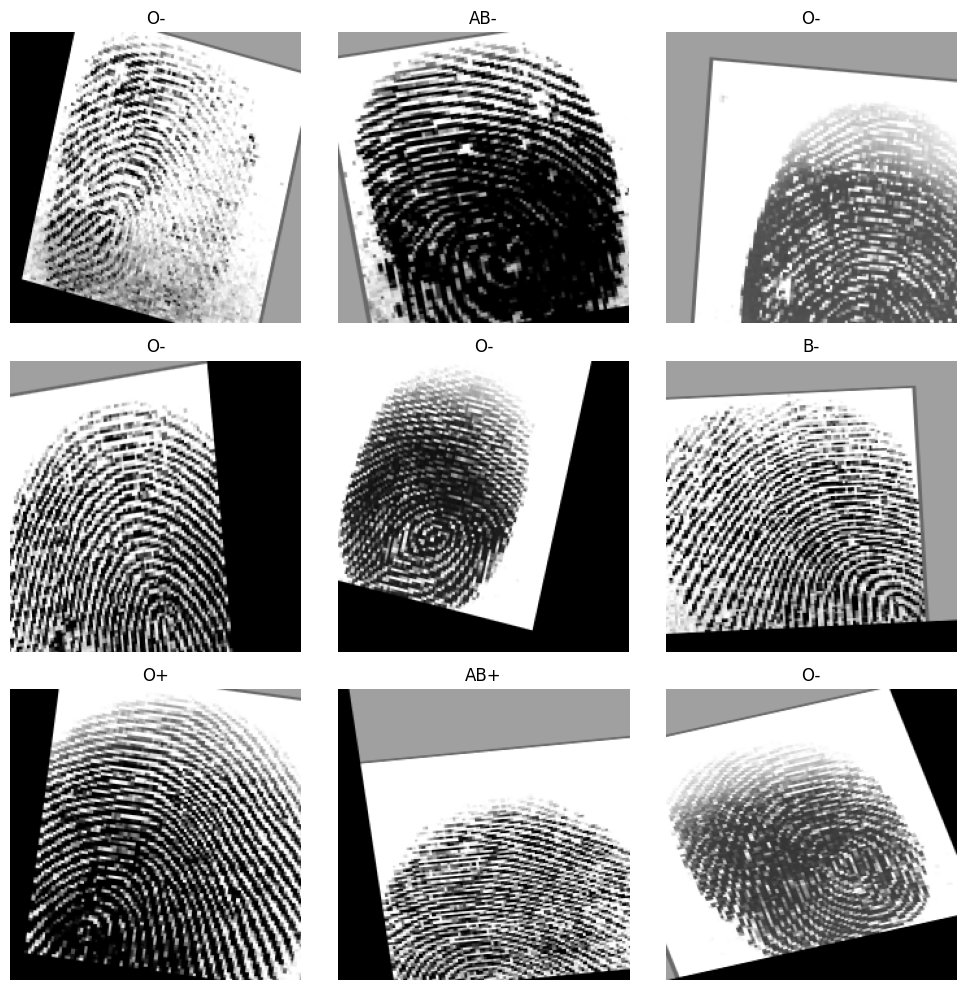

In [5]:
# Display sample images
def show_batch(image_batch, label_batch, class_indices):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i])
        
        # Convert one-hot encoded label back to class name
        label_idx = np.argmax(label_batch[i])
        class_names = {v: k for k, v in class_indices.items()}
        title = class_names[label_idx]
        
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get a batch of training images and labels
image_batch, label_batch = next(iter(train_generator))
show_batch(image_batch, label_batch, train_generator.class_indices)

In [6]:
# CNN Model Architecture
model = Sequential([
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Third Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Fourth Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the results to feed into dense layer
    Flatten(),
    
    # Dense hidden layer
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    
    # Output layer
    Dense(len(blood_groups), activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [7]:
# Callbacks
checkpoint = ModelCheckpoint(
    'blood_group_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

callbacks = [checkpoint, early_stopping]

In [8]:
# Train the model
epochs = 50

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks
)

Epoch 1/50
150/150 [==============================] - ETA: 0s - loss: 2.0077 - accuracy: 0.2027
Epoch 1: val_accuracy improved from -inf to 0.23395, saving model to blood_group_model_best.h5
150/150 [==============================] - 207s 1s/step - loss: 2.0077 - accuracy: 0.2027 - val_loss: 1.9727 - val_accuracy: 0.2340
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 1.8564 - accuracy: 0.2693
Epoch 2: val_accuracy improved from 0.23395 to 0.32179, saving model to blood_group_model_best.h5
150/150 [==============================] - 184s 1s/step - loss: 1.8564 - accuracy: 0.2693 - val_loss: 1.7718 - val_accuracy: 0.3218
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 1.7668 - accuracy: 0.3083
Epoch 3: val_accuracy improved from 0.32179 to 0.36233, saving model to blood_group_model_best.h5
150/150 [==============================] - 209s 1s/step - loss: 1.7668 - accuracy: 0.3083 - val_loss: 1.6407 - val_accuracy: 0.3623
Epoch 4/50
150/150 [=====

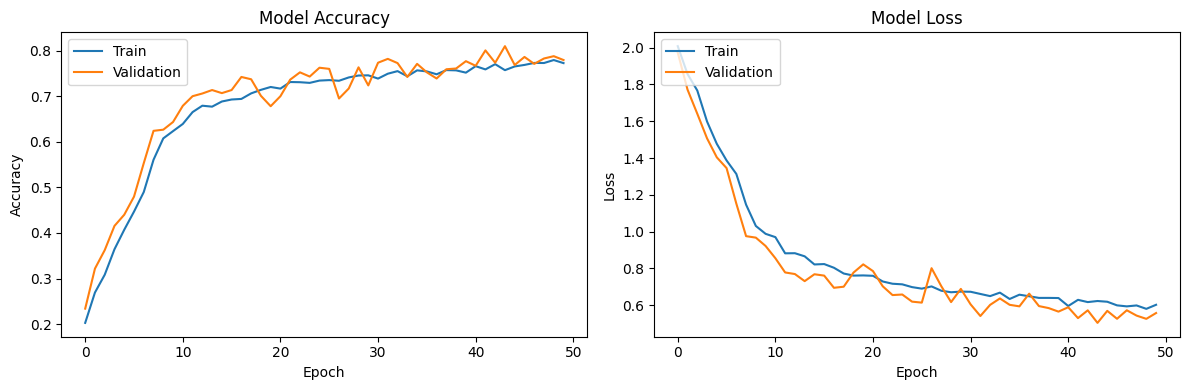

In [10]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
# Evaluate the model on validation set
validation_generator.reset()
y_pred = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true classes
validation_generator.reset()
y_true = []
for i in range(len(validation_generator)):
    _, label_batch = next(validation_generator)
    y_true.extend(np.argmax(label_batch, axis=1))
y_true = y_true[:len(y_pred_classes)]  # Make sure lengths match

38/38 [==============================] - 19s 457ms/step


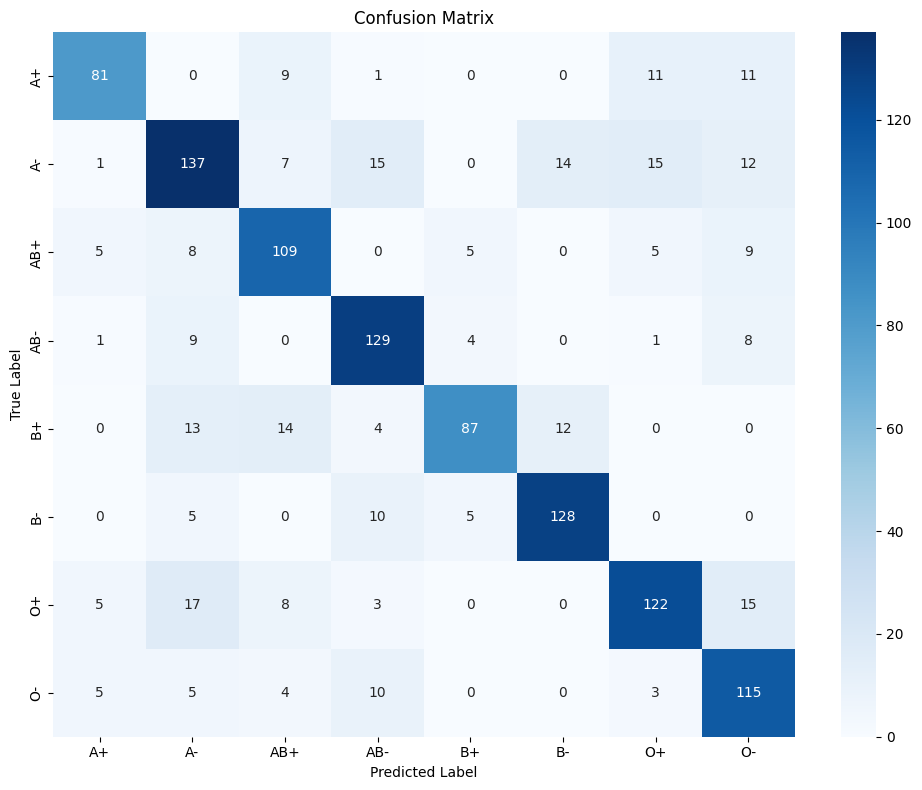

              precision    recall  f1-score   support

          A+       0.83      0.72      0.77       113
          A-       0.71      0.68      0.69       201
         AB+       0.72      0.77      0.75       141
         AB-       0.75      0.85      0.80       152
          B+       0.86      0.67      0.75       130
          B-       0.83      0.86      0.85       148
          O+       0.78      0.72      0.75       170
          O-       0.68      0.81      0.74       142

    accuracy                           0.76      1197
   macro avg       0.77      0.76      0.76      1197
weighted avg       0.76      0.76      0.76      1197



In [12]:
# Get class names
class_indices = validation_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(class_names.values()),
            yticklabels=list(class_names.values()))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=list(class_names.values())))

In [13]:
# Save the final model
model.save('blood_group_model_final.h5')
print("Model saved successfully!")

Model saved successfully!


In [14]:
# Function for making predictions on a new fingerprint image
def predict_blood_group(image_path):
    from tensorflow.keras.preprocessing import image
    
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])
    predicted_blood_group = class_names[predicted_class]
    confidence = prediction[0][predicted_class] * 100
    
    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_blood_group} (Confidence: {confidence:.2f}%)")
    plt.axis('off')
    plt.show()
    
    # Print probabilities for all classes
    for i, prob in enumerate(prediction[0]):
        print(f"{class_names[i]}: {prob*100:.2f}%")
    
    return predicted_blood_group, confidence

1/1 [==============================] - 0s 275ms/step


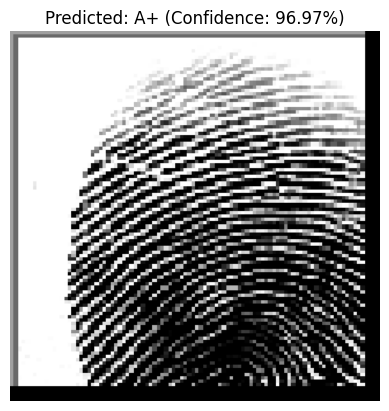

A+: 96.97%
A-: 0.00%
AB+: 0.00%
AB-: 0.00%
B+: 0.00%
B-: 0.00%
O+: 3.02%
O-: 0.00%


In [15]:
# Test prediction with a sample image from validation set
# You can replace this with your own test image path
sample_blood_group = list(class_names.values())[0]
sample_dir = os.path.join(dataset_path, sample_blood_group)
sample_images = os.listdir(sample_dir)

if sample_images:
    sample_image_path = os.path.join(sample_dir, sample_images[0])
    predict_blood_group(sample_image_path)